In [ ]:
"""
Purpose: To test computing of the confusion matrix for the following:
1) On all of the previously automatically labeled data compared to the proofread version

2) Efficiency of one older auatomatically labeled neuron in comparison to the newer automated version

"""



# Trying new way of generating the confusion matrix for all of the data

In [ ]:
import datajoint as dj
import numpy as np

dj.config["database.host"] = "10.28.0.34"
dj.config["database.user"] = "celiib"
dj.config["database.password"] = "newceliipass"
dj.config["safemode"] = True
dj.config["display.limit"] = 20

In [ ]:
pinky = dj.create_virtual_module("pinky","microns_pinky")
schema = dj.schema("microns_pinky")

In [ ]:
pinky.WholeAutoAnnotationsClusters3Optimized() & (dj.U("segment_id") & pinky.ProofreadLabel.proj())

In [ ]:
#tables to juxtapose: 
labels_Table = pinky.WholeAutoAnnotationsClusters3Optimized()
proof_Table = pinky.ProofreadLabel()

In [ ]:
#for the optimized lables, creates a lookup where keys are segments and values are the numpy array of the labels
seg_id,triangles = pinky.WholeAutoAnnotationsClusters3Optimized.proj("triangles").fetch("segment_id","triangles")
auto_classifier_data = dict(list(zip(seg_id,triangles)))
auto_classifier_data

In [ ]:
#for the proofread lables, creates a lookup where keys are segments and values are the numpy array of the labels
seg_id,triangles = pinky.ProofreadLabel.proj("triangles").fetch("segment_id","triangles")
proofread_data = dict(list(zip(seg_id,triangles)))
#proofread_data

In [ ]:
"""
Steps for computing the overall confusion matrix
1) for each neuron go and get the proofread label answer, the automated answers
2) Generate the confusion matrix and add to local variable
3) Iterate through all neurons ids and add the confusion matrix to the total
4) Send the confusion matrix to the function that will plot it
"""

In [ ]:
pinky.LabelKey()

In [ ]:
total_labels = [k for k in range(2,14) if k != 9]
total_labels

In [ ]:
len(auto_classifier_data.keys())

In [ ]:
"""
Iterates through all of the neurons:
1) generates a confusion matrix between the auto and the proofread version
2) Add that individual confusion matrix to the whole one

"""

from sklearn.metrics import confusion_matrix
from tqdm import tqdm
cm_total = None

for seg_id,tri in tqdm(proofread_data.items()):
    if seg_id not in auto_classifier_data.keys():
        continue
    
    #get the triangle labels from the automated run
    auto_tri = auto_classifier_data[seg_id].astype("int")
    auto_tri[np.where(auto_tri>= 13)] = 13
    
    
    #get a confusion matrix 
    
    cm = confusion_matrix(tri, auto_tri,labels=total_labels)
    
    if not(type(cm_total) is np.ndarray):
        cm_total = cm
    else:
        cm_total = cm_total + cm
    

In [ ]:
#shows the confusion matrix is just the raw numbers that match or don't match
cm = confusion_matrix(tri, auto_tri,labels=total_labels)
cm

In [ ]:
# import numpy as np
# cm_total_npz = np.load("cm_total.npz")
# cm_total = cm_total_npz["cm_total"]
# classes = cm_total_npz["classes"]

In [ ]:
pinky.LabelKey()

In [ ]:
Label_key_data = pinky.LabelKey.fetch(as_dict=True)
kept_data = Label_key_data[2:9] + Label_key_data[10:13]
kept_data

#assembles the numbers and and names for the labels from 2:8, 10:13 (13 is other)
classes = [k["description"] for k in kept_data]
cm_labels = [k["numeric"] for k in kept_data]
classes.append("unknown")
cm_labels.append(13)
print((classes,cm_labels))

In [ ]:
classes

In [ ]:
np.savez("cm_total.npz",cm_total=cm_total,classes=classes,cm_labels=cm_labels)

# Load in the confusion matrix and display it

In [1]:
import celii_confusion_plotting as cp

In [2]:
import numpy as np
cm_total_npz = np.load("cm_total.npz")
cm_total = cm_total_npz["cm_total"]
cm_labels = cm_total_npz["cm_labels"]
classes = cm_total_npz["classes"]

/notebooks/Users/celii/Documents/Complete_Pinky100_Pipeline/notebooks/Pass_2_Analysis/Whole_Classifier_Efficiency/celii_confusion_plotting.py:108: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf535e6cf8>,
 <Figure size 1440x864 with 2 Axes>)

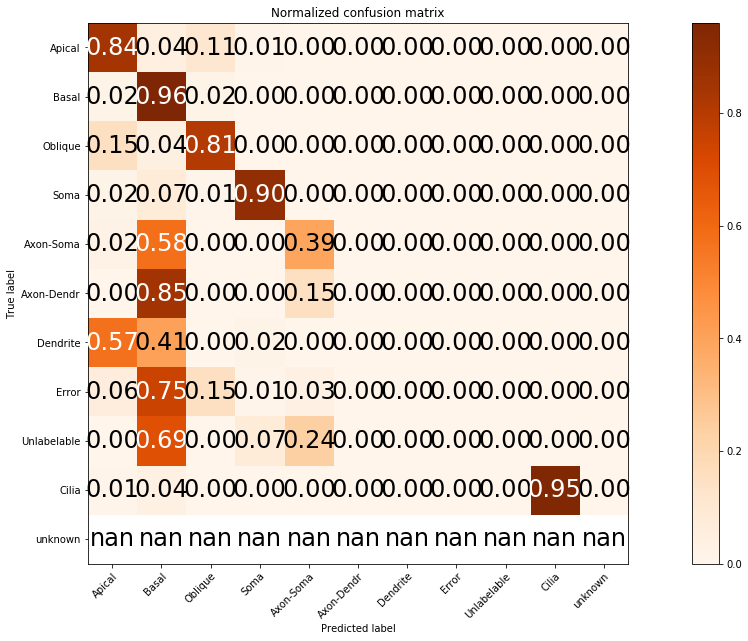

In [3]:
import matplotlib.pyplot as plt
cp.plot_confusion_matrix_from_confusion_matrix(cm_total,classes=classes,cmap=plt.cm.Oranges)

In [ ]:
# make a restricted table:
import matplotlib.pyplot as plt
cp.plot_confusion_matrix_from_confusion_matrix(cm_total,classes=classes,cmap=plt.cm.Greens)

In [ ]:
# make a restricted table:
import matplotlib.pyplot as plt
cp.plot_confusion_matrix_from_confusion_matrix(cm_total[:5,:5],classes=classes[:5],cmap=plt.cm.Greens)

In [ ]:
# Calculates the accuracy and precision:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

accuracy_score(y_true, y_pred, normalize=False)

In [ ]:
#precision, recall and accuracy

Accuracy = Total Correct / (Total Data)
Precision = True Positives / (True Positive + False Positive) = True Positive / (All those predicted as postive)
Recall = True Positive / (True Positive + False Negative) = True Positive / (All those actually in that category)

In [ ]:
#compute overall accuracy:
total_accuracy = np.sum(np.diagonal(cm_total))/np.sum(cm_total)
total_accuracy

In [ ]:
classes

# Makes the abridged table

In [5]:
classes = list(classes[:4]) + ["Axon"] + list(classes[9:10])

In [6]:
cm_col_axon_grouped = np.column_stack([cm_total[:,:4],np.sum(cm_total[:,4:6],axis=1),cm_total[:,9:10]])
cm_axon_grouped = np.row_stack([cm_col_axon_grouped[:4,:],np.sum(cm_col_axon_grouped[4:6,:],axis=0),cm_col_axon_grouped[9:10,:]])
cm_axon_grouped
#cm_col_axon_grouped = np.row_stack()

array([[ 34395948,   1705778,   4390566,    249561,     81199,     35766],
       [  3032548, 163436604,   2818373,    347510,    528605,     34000],
       [  2960950,    751801,  15664264,      6166,         0,       325],
       [   304691,   1325280,    117889,  16326599,     51273,      8321],
       [   163723,   5694939,     17491,     13639,   3313573,       874],
       [      860,      3333,         0,        24,         0,     87739]])

Normalized confusion matrix


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


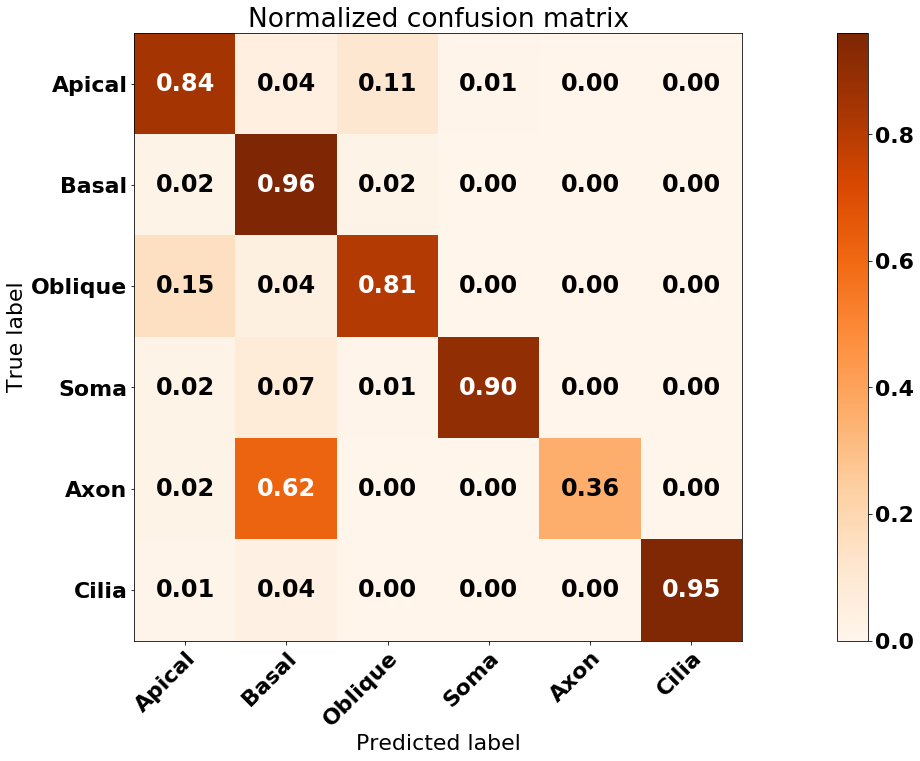

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
ax,fig = cp.plot_confusion_matrix_from_confusion_matrix(cm_axon_grouped,classes=classes,cmap=plt.cm.Oranges)
fig.set_size_inches(40,24)



# Computes the ABRIDGED Statistics:

In [8]:
#get the percision for each category
#cm_abridged = cm_total[:-6,:-6]  # working

cm_abridged = cm_axon_grouped
classes_abridges = classes
precision_category = np.diagonal(cm_abridged)/np.sum(cm_abridged,axis=0)
recall_category = np.diagonal(cm_abridged)/np.sum(cm_abridged,axis=1)
f1 = 2*(precision_category*recall_category)/(precision_category + recall_category )
precision_category
accuracies = np.vstack([precision_category,recall_category,f1])

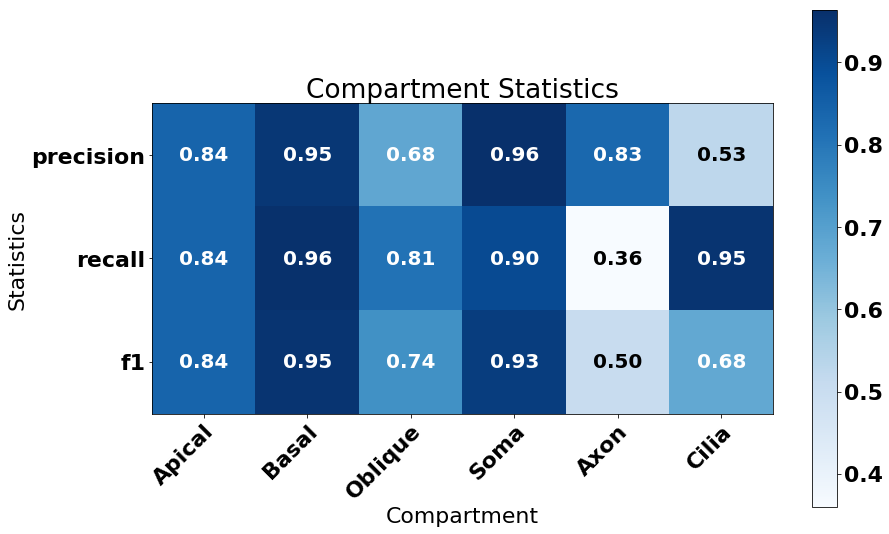

In [9]:
cm = accuracies
normalize = True
cmap=plt.cm.Blues
#now graph the results for all the categories
title = "Compartment Statistics"

fig, ax = plt.subplots()
im = ax.imshow(accuracies, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(accuracies.shape[1]),
       yticks=np.arange(accuracies.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes_abridges, yticklabels=["precision","recall","f1"],
       title=title,
       ylabel='Statistics',
       xlabel='Compartment')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = np.nanmax(cm) / 2.
thresh = 0.6
#print("threshold = " + str(thresh))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        #print("cm[i,j] = " + str(cm[i,j]))
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
               fontsize=20)
fig.tight_layout()

fig.set_size_inches(20, 12)
ax.grid(False)


In [ ]:


help(ax.text)

In [ ]:
cm_abridged

In [ ]:
x = np.array([[1,2],[10,20]])
np.sum(x,axis=1)

In [ ]:
x